In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

import datetime
import os

Using TensorFlow backend.


In [2]:
### 데이터 로드
data = pd.read_csv('dataset/ethereum_dataset.csv', index_col=0)
data.head()

,Open*,High,Low,Close**,Volume,Market Cap
Date,,,,,,
2019-08-13,211.34,211.38,205.42,208.71,5946313205,2.239653e+10
2019-08-12,216.06,216.14,210.95,211.29,5674315559,2.267042e+10
2019-08-11,206.73,216.60,206.51,216.09,6440605605,2.318300e+10
2019-08-10,210.53,213.73,203.79,206.73,6584748527,2.217611e+10
2019-08-09,220.91,221.36,208.25,210.49,6964818795,2.257606e+10


In [3]:
### 데이터 전처리
high_prices = data['High'].values
low_prices = data['Low'].values

mid_prices = (high_prices + low_prices) / 2

seq_len = 30
sequence_length = seq_len + 1

price = []
for index in range(len(mid_prices) - sequence_length):
    price.append(mid_prices[index: index + sequence_length])

In [4]:
### 데이터 정규화 - price
def price_normalize_windows(data):
    normalized_data = []

    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
        
    return np.array(normalized_data)

norm_price = price_normalize_windows(price)

In [5]:
### 데이터 정규화 - volume
def volume_normalize_windows(data):
    normalized_data = []
    avg_window = sum(data, 0.0) / len(data)
    
    for window in data:
        normalized_window = (window / avg_window) -1
        normalized_data.append(normalized_window)

    return np.array(normalized_data)

volume_data = data['Volume'].values

norm_volume = volume_normalize_windows(volume_data)


In [6]:
### 데이터 분할
def data_gethering(price, volume):    
    data_size = price.shape[0]
    result =[]

    for i in range(data_size):
        temp = np.insert(price[i],-1,volume[i])
        result.append(temp)
        
    return np.array(result)

norm_result = data_gethering(norm_price, norm_volume)

In [7]:
train_cut = -90 # 마지막 3달의 데이터를 test데이터로 한다
# int(round(norm_result.shape[0] * 0.90))
        
train = norm_result[:train_cut, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = norm_result[train_cut:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = norm_result[train_cut:, -1]

x_train.shape, x_test.shape

((1347, 31, 1), (90, 31, 1))

In [8]:
### 모델 체크포인터 롤백
MODEL_SAVE_FOLBER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLBER_PATH):
    os.mkdir(MODEL_SAVE_FOLBER_PATH)
    
model_path = MODEL_SAVE_FOLBER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

# 체크포인트 생성 코드
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='auto')

In [9]:
### 모델 설계
model = Sequential()

for i in range (4):
    model.add(LSTM(31, return_sequences=True, input_shape=(31, 1)))   

model.add(LSTM(31, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

W0826 14:38:33.100063 21600 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 14:38:33.122026 21600 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 14:38:33.124524 21600 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 14:38:33.837381 21600 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 31, 31)            4092      
_________________________________________________________________
lstm_2 (LSTM)                (None, 31, 31)            7812      
_________________________________________________________________
lstm_3 (LSTM)                (None, 31, 31)            7812      
_________________________________________________________________
lstm_4 (LSTM)                (None, 31, 31)            7812      
_________________________________________________________________
lstm_5 (LSTM)                (None, 31)                7812      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 32        
Total params: 35,372
Trainable params: 35,372
Non-trainable params: 0
_________________________________________________________________


In [9]:
### 학습 모델 로드
model = load_model('ether_prediction_model_achi_1.h5')
# model = load_model('ether_prediction_model_achi_2.h5')
# model = load_model('ether_prediction_model_achi_3.h5')

W0925 15:42:43.027387 23712 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0925 15:42:43.045891 23712 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0925 15:42:43.048891 23712 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0925 15:42:43.808652 23712 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0925 15:42:43.809661 23712 depr

In [11]:
### 모델 학습
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=30, callbacks=[cb_checkpoint])

W0826 14:38:36.979815 21600 deprecation.py:323] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0826 14:38:39.179798 21600 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0826 14:38:39.185779 21600 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1347 samples, validate on 90 samples
Epoch 1/30
1347/1347 [==============================] - 15s 11ms/step - loss: 0.0531 - val_loss: 0.0848

Epoch 00001: val_loss improved from inf to 0.08478, saving model to ./model/01-0.0848.hdf5
Epoch 2/30
1347/1347 [==============================] - 10s 8ms/step - loss: 0.0267 - val_loss: 0.0648

Epoch 00002: val_loss improved from 0.08478 to 0.06480, saving model to ./model/02-0.0648.hdf5
Epoch 3/30
1347/1347 [==============================] - 10s 8ms/step - loss: 0.0213 - val_loss: 0.0653

Epoch 00003: val_loss did not improve from 0.06480
Epoch 4/30
1347/1347 [==============================] - 10s 7ms/step - loss: 0.0187 - val_loss: 0.0571

Epoch 00004: val_loss improved from 0.06480 to 0.05713, saving model to ./model/04-0.0571.hdf5
Epoch 5/30
1347/1347 [==============================] - 10s 8ms/step - loss: 0.0158 - val_loss: 0.0547

Epoch 00005: val_loss improved from 0.05713 to 0.05473, saving model to ./model/05-0.0547.hdf5
Epoch 

In [13]:
## 모델 저장
model. save('ether_prediction_model_achi_1.h5')

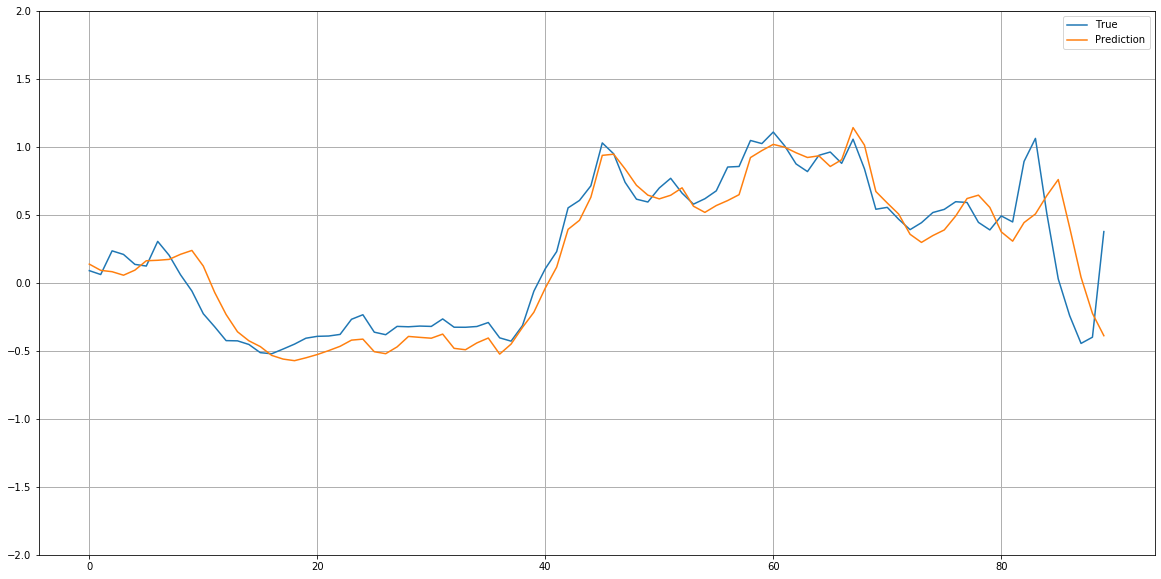

In [10]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
ax.grid(linestyle='-', linewidth=1,)
plt.ylim([-2, 2])
plt.show()